In [2]:
import os
import pandas as pd
import numpy as np
import ast


# -------------------------------
# HELPER: parse list-like strings
# -------------------------------

def parse_list(s):
    """Convert string like '[0.2, 0.1, 0.05]' into list of floats."""
    if isinstance(s, list):
        return s
    return ast.literal_eval(s)


# -------------------------------
# METRIC EXTRACTION LOGIC

def aggregate_performance(csv_path):
    df = pd.read_csv(csv_path)

    # Convert list-like string columns to actual lists
    df["particle_dist"] = df["evaluation/mean_particle_distance"].apply(parse_list)
    df["semantic_dist"] = df["evaluation/semantic_keypoint_distance"].apply(parse_list)
    df["iou"] = df["evaluation/max_IoU"].apply(parse_list)
    df["iou_flat"] = df["evaluation/max_IoU_to_flattened"].apply(parse_list)
    df["nc"] = df["evaluation/normalised_coverage"].apply(parse_list)
    df["success_list"] = df["evaluation/success"].apply(parse_list)

    # ---------------------------
    # Extract per-row statistics
    # ---------------------------

    min_particle_distance = [np.min(x) for x in df["particle_dist"]]
    min_semantic_distance = [np.min(x) for x in df["semantic_dist"]]

    max_max_iou = [np.max(x) for x in df["iou"]]
    max_iou_flat = [np.max(x) for x in df["iou_flat"]]
    max_nc = [np.max(x) for x in df["nc"]]

    last_particle_distance = [x[-1] for x in df["particle_dist"]]
    last_semantic_distance = [x[-1] for x in df["semantic_dist"]]
    last_max_iou = [x[-1] for x in df["iou"]]

    # ---------------------------
    # Success + steps-to-finish
    # ---------------------------

    first_success_flags = []
    final_success_flags = []
    steps_to_first_success = []

    for success_list in df["success_list"]:
        if any(success_list):
            first_success_flags.append(1)
            steps_to_first_success.append(success_list.index(True))
        else:
            first_success_flags.append(0)
            steps_to_first_success.append(len(success_list) - 1)
        if success_list[-1]:
            final_success_flags.append(1)
        else:
            final_success_flags.append(0)

    # ---------------------------
    # Aggregated metrics (means)
    # ---------------------------

    min_particle_mean = np.mean(min_particle_distance)
    last_particle_mean = np.mean(last_particle_distance)

    min_semantic_mean = np.mean(min_semantic_distance)
    last_semantic_mean = np.mean(last_semantic_distance)

    max_iou_mean = np.mean(max_max_iou)
    max_iou_flat_mean = np.mean(max_iou_flat)
    last_iou_mean = np.mean(last_max_iou)
    max_nc_mean = np.mean(max_nc)

    first_success_rate = np.mean(first_success_flags)
    final_success_rate = np.mean(final_success_flags)
    print('final_success_flags', final_success_flags)

    # ---------------------------
    # Standard deviations
    # ---------------------------
    max_iou_flat_std = np.std(max_iou_flat)
    min_particle_std = np.std(min_particle_distance)
    last_particle_std = np.std(last_particle_distance)

    min_semantic_std = np.std(min_semantic_distance)
    last_semantic_std = np.std(last_semantic_distance)

    max_iou_std = np.std(max_max_iou)
    last_iou_std = np.std(last_max_iou)

    max_nc_std = np.std(max_nc)

    # ---------------------------
    # Episode counts
    # ---------------------------

    num_episodes = len(df)
    first_success_episodes = int(np.sum(first_success_flags))
    final_success_episodes = int(np.sum(final_success_flags))
    steps_to_finish_mean = np.mean(steps_to_first_success)
    steps_to_finish_std = np.std(steps_to_first_success)

    return {
        # Means
        "min_particle_distance_mean": min_particle_mean,
        "last_particle_distance_mean": last_particle_mean,
        "min_semantic_distance_mean": min_semantic_mean,
        "last_semantic_distance_mean": last_semantic_mean,
        "max_IoU_mean": max_iou_mean,
        "max_IoU_to_flattened_mean": max_iou_flat_mean,
        "max_NC_mean": max_nc_mean, 
        "last_IoU_mean": last_iou_mean,
        "steps_to_first_success_mean": steps_to_finish_mean,

        # Standard deviations
        "min_particle_distance_std": min_particle_std,
        "last_particle_distance_std": last_particle_std,
        "min_semantic_distance_std": min_semantic_std,
        "last_semantic_distance_std": last_semantic_std,
        "max_IoU_std": max_iou_std,
        "last_IoU_std": last_iou_std,
        "max_IoU_to_flattened_std": max_iou_flat_std,
        "steps_to_first_success_std": steps_to_finish_std,
        "max_NC_std": max_nc_std, 

        # Others
        "first_success_rate": first_success_rate,
        "final_success_rate": final_success_rate,
        "num_episodes": num_episodes,
        "first_success_episodes": first_success_episodes,
        "final_success_episodes": final_success_episodes
    }

In [3]:
# We evaluate the ability to flattening, ablilty to folding and ability to recover from failed folding states.
# first success in a trajectory --> ability to folding
# final step success in a trajectory --> ability to recognise success and recover from failures.
import glob

data_dir = "../tmp/garment_folding_data"
experiments = [
    # {
    #     "name": "human_multi_primitive_multi_longsleeve_folding_from_crumpled",
    #     "label": "Human (2, M)"
    # },
    {
        "name": "random_multi_primitive_multi_longsleeve_folding_from_crumpled",
        "label": "Random (2, M)",
    },
    {
        "name": "iou_based_stitching_dual_picker_multi_primitive_multi_longsleeve_folding_from_crumpled_workspace",
        "label": "IoU-Stitch(2, S)"
    },
    {
        "name": "vlm_qwen3_2b_it_based_stitching_dual_picker_multi_primitive_multi_longsleeve_folding_from_crumpled_workspace",
        "label": "VLM-Stitch(2, S)"
    },
]

rows = []
for exp in experiments:
    

# Find the eval_checkpoint directory (assuming there's only one)
    eval_dirs = glob.glob(os.path.join(data_dir, exp["name"], "eval_checkpoint*"))

    # csv_path = os.path.join(
    #     data_dir,
    #     exp["name"],
    #     "eval_checkpoint_-1",
    #     "performance.csv"
    # )
    eval_dir = eval_dirs[0]  # or choose based on your logic
    csv_path = os.path.join(eval_dir, "performance.csv")

    
    print('csv', csv_path)
    if not os.path.exists(csv_path):
        print(f"WARNING: Missing file: {csv_path}")
        continue

    metrics = aggregate_performance(csv_path)
    metrics["experiment"] = exp["label"]
    rows.append(metrics)

results_df = pd.DataFrame(rows)
cols = ["experiment"] + [c for c in results_df.columns if c != "experiment"]
results_df = results_df[cols]
display(results_df)

# results_df

csv ../tmp/garment_folding_data/random_multi_primitive_multi_longsleeve_folding_from_crumpled/eval_checkpoint_-1/performance.csv
final_success_flags [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
csv ../tmp/garment_folding_data/iou_based_stitching_dual_picker_multi_primitive_multi_longsleeve_folding_from_crumpled_workspace/eval_checkpoint_-1/performance.csv
final_success_flags [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0]
csv ../tmp/garment_folding_data/vlm_qwen3_2b_it_based_stitching_dual_picker_multi_primitive_multi_longsleeve_folding_from_crumpled_workspace/eval_checkpoint_-1/performance.csv
final_success_flags [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


,experiment,min_particle_distance_mean,last_particle_distance_mean,min_semantic_distance_mean,last_semantic_distance_mean,max_IoU_mean,max_IoU_to_flattened_mean,max_NC_mean,last_IoU_mean,steps_to_first_success_mean,...,max_IoU_std,last_IoU_std,max_IoU_to_flattened_std,steps_to_first_success_std,max_NC_std,first_success_rate,final_success_rate,num_episodes,first_success_episodes,final_success_episodes
0,"Random (2, M)",0.127980,0.158547,0.149733,0.193487,0.766183,0.580303,0.661193,0.61274,20.000000,...,0.055630,0.157535,0.076797,0.000000,0.089269,0.000000,0.000000,30,0,0
1,"IoU-Stitch(2, S)",0.113707,0.161077,0.138313,0.205790,0.749440,0.802027,0.942817,0.54982,28.266667,...,0.082910,0.171865,0.064731,4.661426,0.056057,0.200000,0.200000,30,6,6
2,"VLM-Stitch(2, S)",0.111813,0.161847,0.139133,0.200960,0.775043,0.725203,0.818457,0.62781,29.666667,...,0.063488,0.145395,0.107142,1.619328,0.126764,0.066667,0.033333,30,2,1


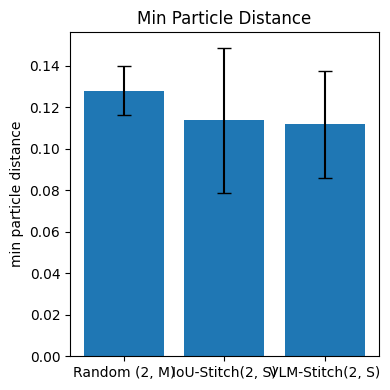

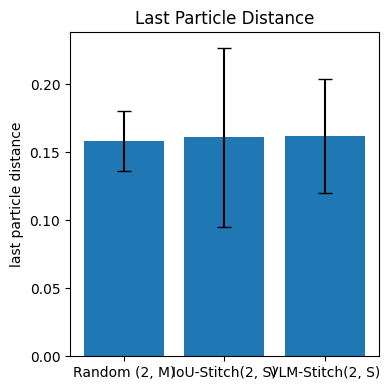

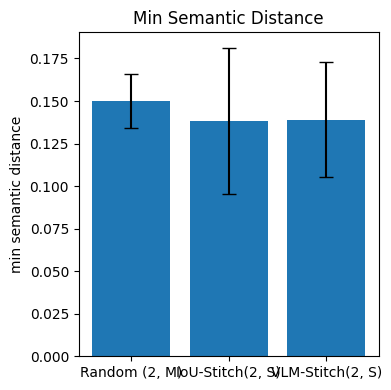

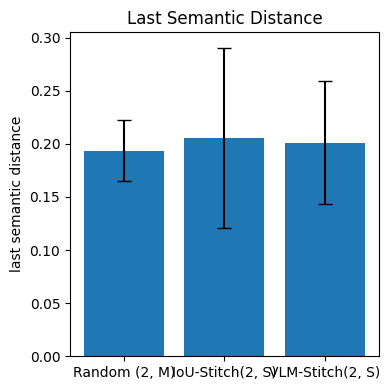

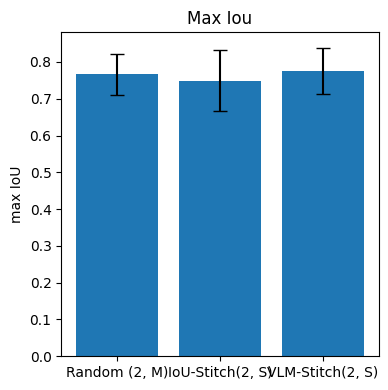

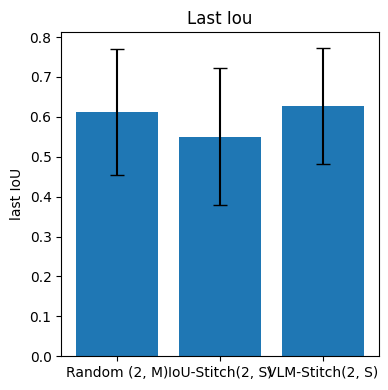

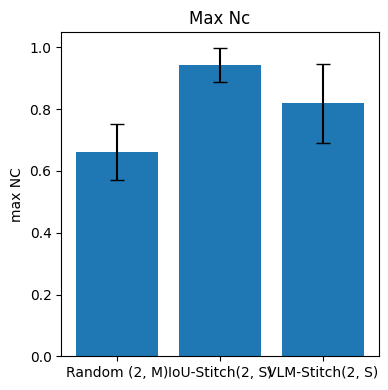

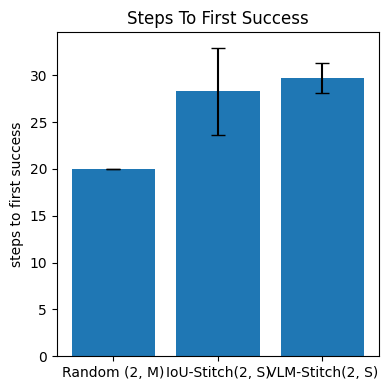

In [4]:
import matplotlib
# matplotlib.use("Agg")  # non-interactive, stable

import matplotlib.pyplot as plt

import numpy as np

# List of metrics you want to plot (base names without _mean / _std)
metrics = [
    "min_particle_distance",
    "last_particle_distance",
    "min_semantic_distance",
    "last_semantic_distance",
    "max_IoU",
    "last_IoU",
    "max_NC",
    "steps_to_first_success",
]

experiments = results_df["experiment"]

for metric in metrics:
    mean_col = f"{metric}_mean"
    std_col = f"{metric}_std"

    means = results_df[mean_col]
    stds = results_df[std_col]

    x = np.arange(len(experiments))

    plt.figure(figsize=(4, 4))
    plt.bar(x, means, yerr=stds, capsize=5)
    plt.xticks(x, experiments)
    plt.ylabel(metric.replace("_", " "))
    plt.title(f"{metric.replace('_', ' ').title()}")

    plt.tight_layout()
    plt.show()


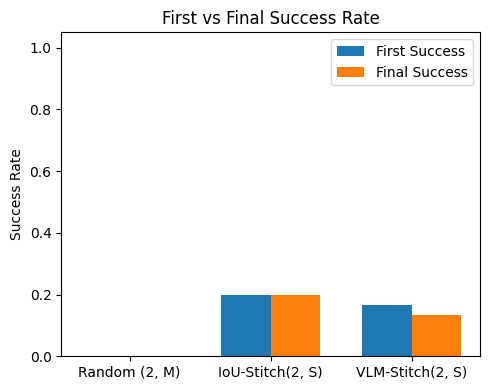

In [4]:
import matplotlib.pyplot as plt
import numpy as np

experiments = results_df["experiment"]
num_episodes = results_df["num_episodes"]

# Success rates
first_success = results_df["first_success_rate"]
final_success = results_df["final_success_rate"]

x = np.arange(len(experiments))
bar_width = 0.35

plt.figure(figsize=(5, 4))

plt.bar(
    x - bar_width / 2,
    first_success,
    bar_width,
    capsize=5,
    label="First Success",
)

plt.bar(
    x + bar_width / 2,
    final_success,
    bar_width,
    capsize=5,
    label="Final Success",
)

plt.xticks(x, experiments)
plt.ylabel("Success Rate")
plt.ylim(0, 1.05)
plt.legend()
plt.title("First vs Final Success Rate")

plt.tight_layout()
plt.show()


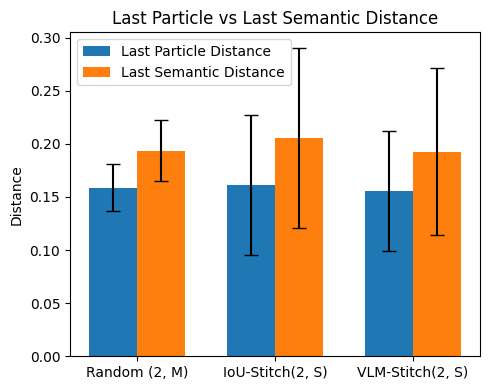

In [5]:
import matplotlib.pyplot as plt
import numpy as np

experiments = results_df["experiment"]
num_episodes = results_df["num_episodes"]

# Metrics
last_particle = results_df["last_particle_distance_mean"]
last_semantic = results_df["last_semantic_distance_mean"]

# Standard error
last_particle_se = results_df["last_particle_distance_std"]
last_semantic_se = results_df["last_semantic_distance_std"]

x = np.arange(len(experiments))
bar_width = 0.35

plt.figure(figsize=(5, 4))

plt.bar(
    x - bar_width/2,
    last_particle,
    bar_width,
    yerr=last_particle_se,
    capsize=5,
    label="Last Particle Distance",
)

plt.bar(
    x + bar_width/2,
    last_semantic,
    bar_width,
    yerr=last_semantic_se,
    capsize=5,
    label="Last Semantic Distance",
)

plt.xticks(x, experiments)
plt.ylabel("Distance")
plt.title("Last Particle vs Last Semantic Distance")
plt.legend()
plt.tight_layout()
plt.show()


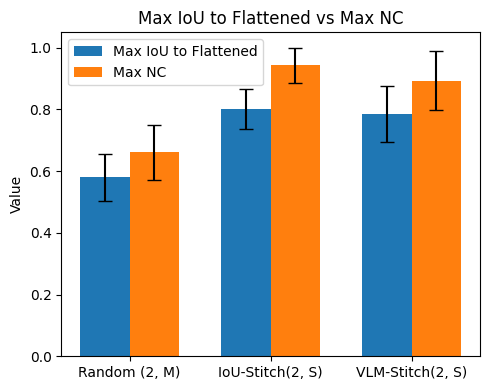

In [6]:
import matplotlib.pyplot as plt
import numpy as np

experiments = results_df["experiment"]
num_episodes = results_df["num_episodes"]

# Metrics
max_iou_flat = results_df["max_IoU_to_flattened_mean"]
max_nc = results_df["max_NC_mean"]

# Standard error
max_iou_flat_se = results_df["max_IoU_to_flattened_std"]
max_nc_se = results_df["max_NC_std"]

x = np.arange(len(experiments))
bar_width = 0.35

plt.figure(figsize=(5, 4))

plt.bar(
    x - bar_width/2,
    max_iou_flat,
    bar_width,
    yerr=max_iou_flat_se,
    capsize=5,
    label="Max IoU to Flattened",
)

plt.bar(
    x + bar_width/2,
    max_nc,
    bar_width,
    yerr=max_nc_se,
    capsize=5,
    label="Max NC",
)

plt.xticks(x, experiments)
plt.ylabel("Value")
plt.ylim(0, 1.05)
plt.title("Max IoU to Flattened vs Max NC")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Define the metrics and whether they have a std column
metrics = [
    ("steps_to_first_success", True),  # has _mean and _std
    ("first_success_rate", False),     # no _mean, no _std
    ("final_success_rate", False),     # no _mean, no _std
    ("last_particle_distance", True),
    ("last_semantic_distance", True),
    ("last_IoU", True),
    ("max_NC", True),
    ("max_IoU_to_flattened", True),
]

# Column labels for LaTeX
column_labels = [
    "S2F(\#)",
    "1st-SR (\%)",
    "Final-SR (\%)",
    "L-MPD (cm)",
    "L-MSD (cm)",
    "LM-IoU (Fold, \%)",
    "Max NC (\%)",
    "MM-IoU (Flat, \%)",
]

# Metrics to scale by 100
scale_100 = ["first_success_rate", "final_success_rate", 
             "last_IoU", "max_NC", "max_IoU_to_flattened", 
             "last_particle_distance", "last_semantic_distance"]

# Start LaTeX table
latex_table = "\\begin{tabular}{l" + "c"*len(metrics) + "}\n"
latex_table += "Experiment & " + " & ".join(column_labels) + " \\\\\n"
latex_table += "\\hline\n"

for idx, row in results_df.iterrows():
    row_values = []
    for metric, has_std in metrics:
        factor = 100 if metric in scale_100 else 1
        if has_std and f"{metric}_mean" in results_df.columns:
            mean_val = row[f"{metric}_mean"] * factor
            std_val = row[f"{metric}_std"] * factor
            row_values.append(f"${mean_val:.1f} \\pm {std_val:.1f}$")
        else:
            val = row[metric] * factor
            row_values.append(f"{val:.1f}")
    latex_table += f"{row['experiment']} & " + " & ".join(row_values) + " \\\\\n"

latex_table += "\\end{tabular}"

print(latex_table)


\begin{tabular}{lcccccccc}
Experiment & S2F(\#) & 1st-SR (\%) & Final-SR (\%) & L-MPD (cm) & L-MSD (cm) & LM-IoU (Fold, \%) & Max NC (\%) & MM-IoU (Flat, \%) \\
\hline
Random (2, M) & $20.0 \pm 0.0$ & 0.0 & 0.0 & $15.9 \pm 2.2$ & $19.3 \pm 2.9$ & $61.3 \pm 15.8$ & $66.1 \pm 8.9$ & $58.0 \pm 7.7$ \\
IoU-Stitch(2, S) & $28.3 \pm 4.7$ & 20.0 & 20.0 & $16.1 \pm 6.6$ & $20.6 \pm 8.5$ & $55.0 \pm 17.2$ & $94.3 \pm 5.6$ & $80.2 \pm 6.5$ \\
VLM-Stitch(2, S) & $20.0 \pm 0.0$ & 0.0 & 0.0 & $16.4 \pm 2.5$ & $20.4 \pm 3.5$ & $54.5 \pm 18.0$ & $81.0 \pm 9.5$ & $66.4 \pm 8.5$ \\
\end{tabular}
